# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Adrien Lüthi and Elias Gajo  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [24]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

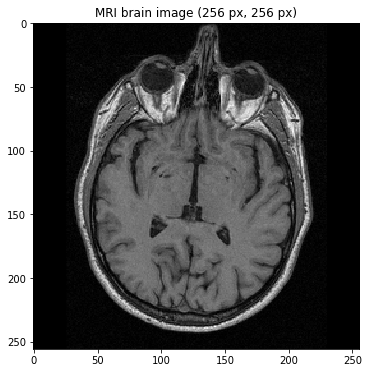

In [25]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('on')
plt.show()

### 1.2 Region growing
Nous pouvons chercher la taille du cerveau par la technique du region growing. L'idée sera donc de faire grossir notre région (correspondant au cerveau) jusqu'à ce que le crâne soit détecté. Il faudra donc choisir un critère d'homogénéité permettant de détecter un pixel du crâne. Nous voyons que les pixels du crâne sont facilement reconnaissables puisqu'ils sont bien blancs. Pour trouver le threshold adéquat (la valeur minimale d'un pixel du crâne), nous pouvons dans un premier temps recourir à l'histogramme.  


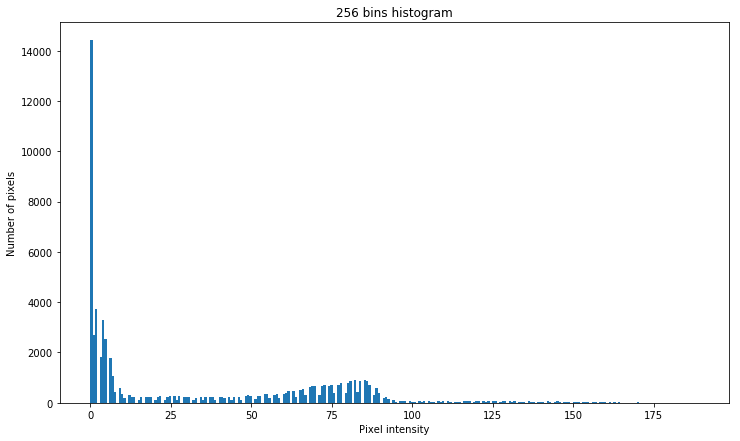

In [26]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

Nous n'arrivons pas à lire clairement un pic pour les intensités correspondant au crâne. Nous allons donc estimer la valeur moyenne d'un pixel du cerveau, et définir un écart maximum (comme critère d'homogénéité). Pour estimer la valeur moyenne d'un pixel du cerveau, visualisons les valeurs des pixels dans une région de l'image correspondant clairement au cerveau. 

In [27]:

valeur_cerveau = brain_im[140:160,60:80]
print(valeur_cerveau)

[[77 76 86 80 83 90 81 92 82 90 90 92 91 90 84 82 90 80 85 85]
 [68 74 82 82 85 84 83 89 85 85 83 86 95 88 83 89 81 77 80 82]
 [57 72 76 77 78 80 87 84 93 92 93 90 93 89 87 92 86 81 78 73]
 [70 73 77 76 76 78 83 84 90 94 88 84 92 96 89 86 82 79 82 78]
 [78 75 78 78 75 84 85 83 84 87 85 81 86 93 90 89 71 79 85 80]
 [84 82 80 84 84 87 82 88 86 89 92 85 84 88 90 90 85 75 74 80]
 [90 89 92 84 87 84 87 84 84 88 86 86 87 88 87 86 80 83 80 81]
 [85 96 88 82 84 87 90 88 88 89 84 87 85 89 82 86 85 80 80 80]
 [81 85 90 88 84 85 85 85 84 84 89 82 82 89 93 87 83 84 81 87]
 [72 74 76 87 85 87 86 85 89 86 88 79 89 84 88 85 87 85 85 88]
 [68 70 74 78 87 91 90 87 83 88 85 86 83 89 92 89 84 83 81 86]
 [69 74 72 72 81 93 90 84 82 89 90 85 81 88 91 88 85 90 84 87]
 [67 70 70 66 72 79 78 87 87 90 89 91 86 85 89 84 88 90 93 84]
 [68 63 67 66 72 73 80 81 81 92 87 82 85 88 87 86 87 92 96 87]
 [67 66 65 73 70 68 70 85 85 89 86 84 87 89 86 85 92 84 90 92]
 [66 73 65 69 62 62 70 78 82 82 86 85 87 85 85 89 90 87

En analysant cette région de l'image et l'histogramme, nous pouvons estimer que la valeur moyenne des pixels du cerveau est de 80. Nous appliquons la même méthode pour trouver la valeur typique d'un pixel du crâne et d'un pixel du background. 

In [28]:
valeur_crane = brain_im[65:75,95:105]
print(valeur_crane)
valeur_background = brain_im[60:70,115:125]
print(valeur_background)


[[ 69  53  54  55  78 124 129 113 143 157]
 [ 84  55  57  58  79 113 142 133 150 118]
 [ 99  73  78  69  80  93 132 134 134  79]
 [137  99 103 110  85  90 129 150  99  64]
 [148 132 129 124  90  74 108 105  76  77]
 [136 159 149 133 120 104 108  84  79 104]
 [129 147 164 152 152 145 136  85  92 121]
 [144 138 145 145 145 161 116  69  85 125]
 [134 138 121 116 145 148 108  81  90 108]
 [135 120 151 118 157 154 110  97  81  96]]
[[26 23 18 18 20  5  6  5 13 18]
 [16 19 23  1 15  8 14 13 19 18]
 [ 9  8 21 12  5 15 28 32 21 17]
 [19  9 13 27 18 13 24 11  4 21]
 [12  9 26 40  7 14 14 12 21 22]
 [16 13 34 13 22  9 12  1 23 35]
 [13 29 21  4 33 10 26 16 14 27]
 [13 33 28 21 29 41 29 33 43 25]
 [19 26 34 31 37 30 28 48 33 30]
 [22 26 43 55 46 41 27 47 45 54]]


J'ai choisis les valeurs initiales en m'inspirant de ces valeurs. J'ai commencé avec une valeur de 110 pour définir le threshold du crâne, et de 40 pour définir celui du background. Après avoir programmé l'algorithme, nous avons modifié un peu les valeurs de threshold initiales pour avoir un bon résultat. 

In [29]:
def regionGrowing(img_in, thresh_l, thresh_h, initial_point):
    import numpy as np
    im_h, im_w = img_in.shape
    img_out = np.zeros((im_h,im_w))
    img_out[initial_point[0], initial_point[1]] = 1
    point = initial_point

    while(len(point) > 1):
        #chercher les voisins du premier point de la liste
        if (point[0] > 0):
            next_point = [point[0] - 1, point[1]]
            val_pix = img_in[next_point[0], next_point[1]]
            if (val_pix > thresh_l and val_pix < thresh_h and img_out[next_point[0], next_point[1]] < 1):
                point = point + next_point
                img_out[next_point[0], next_point[1]] = 1

        if (point[1] > 0):
            next_point = [point[0], point[1] - 1]
            val_pix = img_in[next_point[0], next_point[1]]
            if (val_pix > thresh_l and val_pix < thresh_h and img_out[next_point[0], next_point[1]] < 1):
                point = point + next_point
                img_out[next_point[0], next_point[1]] = 1

        if (point[0] < 255):
            next_point = [point[0] + 1, point[1]]
            val_pix = img_in[next_point[0], next_point[1]]
            if (val_pix > thresh_l and val_pix < thresh_h and img_out[next_point[0], next_point[1]] < 1):
                point = point + next_point
                img_out[next_point[0], next_point[1]] = 1

        if (point[1] < 255):
            next_point = [point[0], point[1] + 1]
            val_pix = img_in[next_point[0], next_point[1]]
            if (val_pix > thresh_l and val_pix < thresh_h and img_out[next_point[0], next_point[1]] < 1):
                point = point + next_point
                img_out[next_point[0], next_point[1]] = 1

        del(point[0])
        del(point[0])
    return img_out

In [30]:
def calculSize (cerveau):
    column = 0
    aire = 0;
    while (column < 255):

        pixel_of_column = 0;
        #search the first and last white pixels
        first = 0;
        while(first < 255):
            if(cerveau[first, column] > 0):
                break
            first = first + 1

        last = 255;
        while(last > 0):
            if(cerveau[last, column] > 0):
                break
            last = last - 1

        if((first ==255) or (last == 0)):
            pixel_of_column = 0
        else:
            pixel_of_column = last - first + 1

        aire = aire + pixel_of_column
        column = column + 1

    rayon = np.sqrt(aire/np.pi)
    taille = 2 * rayon #diamètre
    print("On trouve une taille de",taille, "ce qui parait cohérent en regardant l'image. ")
    return;

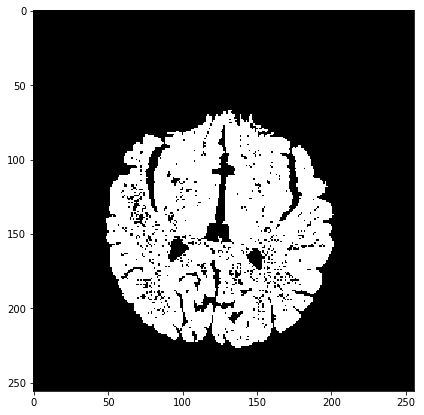

In [31]:
import skimage.filters
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

#threshold pour isoler le cerveau
thresh_h = 90
thresh_l = 50

initial_point = [150,70]
cerveau = regionGrowing(brain_im, thresh_l, thresh_h, initial_point)
plt.figure(figsize=(12, 7))
plt.imshow(cerveau, cmap='gray')
plt.show()

Maintenant que le cerveau est bien isolé du reste, nous pouvons essayer d'estimer sa taille. Nous remarquons que la forme du cerveau est presque ronde. Nous pouvons donc facilement estimer son rayon par la formule A = pi r^2.
Le calcul va donc se faire en 2 temps. D'abord l'aire du cerveau va être estimée en comptant le nombre de pixel délimités par le contour du cerveau. Et ensuite, la taille (le diamètre) va être calculée par rapport à cette aire estimée.

In [32]:
calculSize(cerveau)

On trouve une taille de 153.16474337048123 ce qui parait cohérent en regardant l'image. 


### 1.3 Contour detection
Add your implementation and discussion

On trouve une taille de 152.95261813700307 ce qui parait cohérent en regardant l'image. 


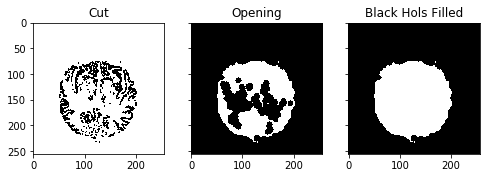

In [33]:
import skimage.filters
import numpy as np
from scipy import ndimage as ndi
from skimage import measure
from skimage import feature
from skimage import filters
from skimage.morphology import reconstruction
from skimage.morphology import binary_closing
from skimage import feature

from skimage.filters import roberts, sobel, scharr, prewitt


markers = np.zeros_like(brain_im)
c = np.ones_like(brain_im)

markers[brain_im <= 60] = 255
markers[brain_im > 55] = 0
markers[brain_im > 78] = 255


cerveau = skimage.morphology.closing(markers, selem=skimage.morphology.selem.disk(1), out=None)
cerveau_cut = np.copy(cerveau)

limit_left = np.arange(49)
for i in limit_left: 
    cerveau_cut[:,i] = 255
    
limit_right = np.arange(203, 256)
for i in limit_right: 
    cerveau_cut[:,i] = 255
    
limit_top = np.arange(0, 75)
for i in limit_top: 
    cerveau_cut[i,:] = 255
    
limit_diag_right_x = np.arange(40, 100)
limit_diag_right_y = np.arange(0, 170)
for j in limit_diag_right_y:
    for i in limit_diag_right_x:
        th_y = np.int(np.ceil((-126/62)*i + 223))
        if j < th_y:
            cerveau_cut[j, i] = 255
            
limit_diag_left_x = np.arange(150, 250)
limit_diag_left_y = np.arange(0, 130)
for j in limit_diag_left_y:
    for i in limit_diag_left_x:
        th_y = np.int(np.ceil((1.6)*i - 200))
        if j < th_y:
            cerveau_cut[j, i] = 255
            

cerveau_open = skimage.morphology.opening(cerveau_cut, selem=skimage.morphology.selem.disk(5), out=None)
cerveau_open = np.invert(cerveau_open)

seed = np.copy(cerveau_open)
seed[1:-1, 1:-1] = cerveau_open.max()
mask = cerveau_open

cerveau_filled = reconstruction(seed, mask, method='erosion')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(8, 4))

ax1.imshow(cerveau_cut, cmap=plt.cm.gray)
ax1.set_title('Cut')

ax2.imshow(cerveau_open, cmap=plt.cm.gray)
ax2.set_title('Opening')

ax3.imshow(cerveau_filled, cmap=plt.cm.gray)
ax3.set_title('Black Hols Filled')

calculSize(cerveau_filled)

### 1.4 Additional method(s)
Add your implementation and discussion

Ici, nous appliquons une méthode simple qui consite à estimer la largeur du cerveau suivant une ligne de coordonnée y = 150. L'algorithme va donc chercher, par le biais de thresholds, le premier et le dernier pixel appartenant au cerveau. La condition se base sur un booléen qui s'active lorsqu'on franchit le crâne, et sur des thresholds reconnaissant un pixel du cerveau. 

In [34]:
#threshold pour isoler le cerveau
import numpy as np
img = brain_im
cerveau = np.copy(img)
threshCrane = 100
threshBlack = 70
y = 150
#detect first brain pixel
xmin = 0
skullReached = False
while(xmin < 255):
    if(cerveau[y,xmin] > threshCrane):
        skullReached = True
    if(cerveau[y,xmin] > threshBlack) and (cerveau[y,xmin] < threshCrane) and skullReached:
        break
    xmin = xmin + 1
skullReached = False
xmax = 255
while(xmin > 0):
    if(cerveau[y,xmax] > threshCrane):
        skullReached = True
    if(cerveau[y,xmax] > threshBlack) and (cerveau[y,xmax] < threshCrane) and skullReached:
        break
    xmax = xmax - 1
size = xmax - xmin
print(size)

161


Ceci nous donne une taille de 161 pixels. Le résultat ressemble aux précédents, même si la technique utilisée est moins formelle.

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [35]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


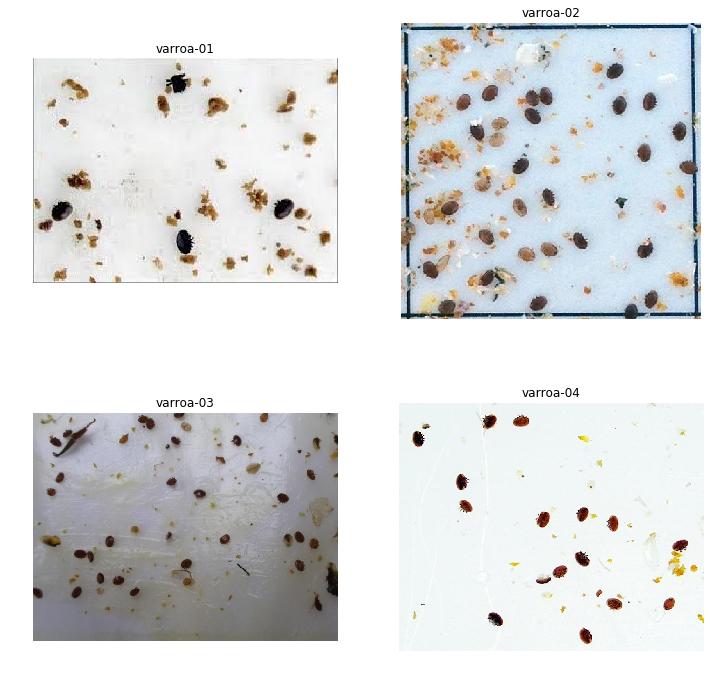

In [36]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [37]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [38]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

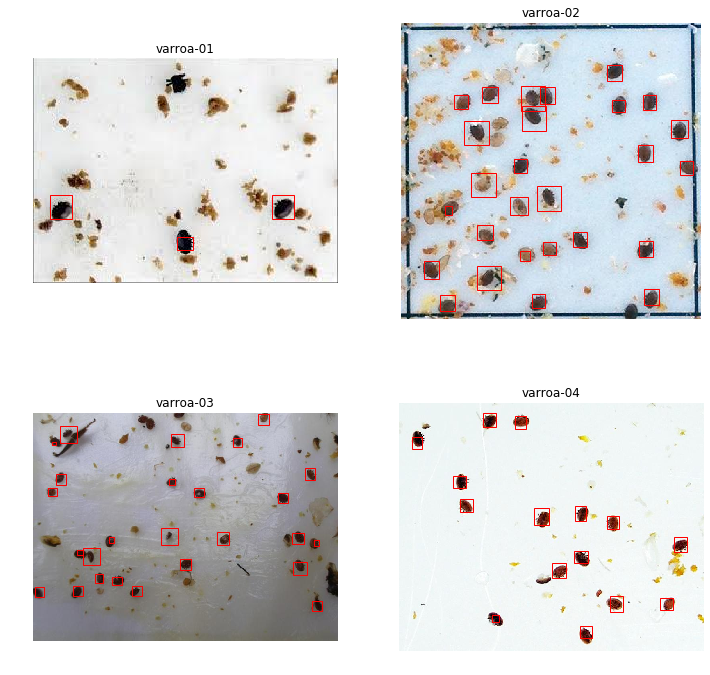

In [39]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

Tout d'abord, regardons quelle plage de couleur nous donne le plus de contraste.

Text(0.5, 1.0, 'Blue channel')

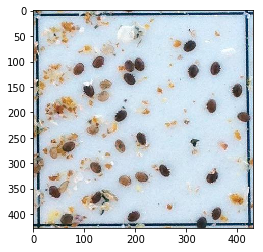

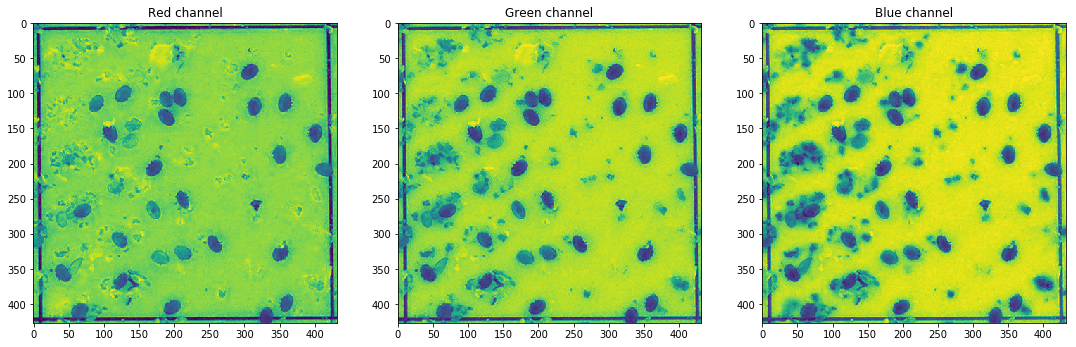

In [66]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.filters
import skimage.color
import numpy as np
from skimage import exposure
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)
img= skimage.io.imread(os.path.join(data_path, 'varroa-02.jpg'))
im_h, im_w, nb_color = img.shape
plt.imshow(img)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
axes[0].imshow(img[:,:,0])
axes[0].set_title("Red channel")
axes[1].imshow(img[:,:,1])
axes[1].set_title("Green channel")
axes[2].imshow(img[:,:,2])
axes[2].set_title("Blue channel")

Nous voyons ici que la plage rouge se prête bien pour isoler les mites du background. Nous nous somme donc basé uniquement sur le rouge pour la suite. Nous aurions pu être plus rigoureux, et chercher numériquement pour chaque image, quelle couleur donne le plus de contraste.
Pour la suite, nous commençons par appliquer la technique du region growing avec un threshold permettant de maximiser nos chances de développer les formes des mites sans développer celles du background. Nous avons donc modifier le threshold pour chaque image, afin d'optimiser les résultats obtenus. 
Comme pour la plupart des images, l'algorithme développait aussi la forme de petits éléments du background, nous avons choisi de remédier à ça en appliquant l'algorithme opening avec un masque adéquat. Le masque qui nous donnait les meilleurs résultats était sans surprise le masque circulaire (puisque les mites sont de forme presque ronde). Nous avons également adapté le rayon de ce masque pour chaque image afin d'optimiser les résultats.
Enfin, comme sur certaines images, il y avait des gros objets appartenant au background, nous avons appliqué un autre algorithme (nommé removeNoise), qui se charge de supprimer toutes les formes trop grandes ou trop petites. La raison était que la taille des mites semblait plutôt constante, contrairement à celle des éléments du background. Cette algorithme calcul la taille moyenne des formes (élaborées par region growing), et l'écart type. Ensuite, il supprime les formes dont la taille s'écarte trop de la moyenne (toutes les formes plus grandes ou plus petites que mean +- facteur * std). Le "facteur" est également un paramètre que nous pouvons modifier pour chaque image.

In [57]:
def completeRegionGrowing(img, thresh_black, tolerance):
    import numpy as np
    x = 0
    im_h, im_w = img.shape
    img_out = np.zeros((im_h, im_w))
    label = 0
    while(x < im_w):
        y = 0
        while(y < im_h):
            if(img[y,x]> thresh_black):
                y = y + 1
                continue
            if(img_out[y,x] > 0): # déja labellé
                y = y + 1
                continue
            # region growing
            initial_point = [y,x]
            val_pix = img[y,x]
            if((val_pix + tolerance) > 255):
                thresh_h = 255
            else:
                thresh_h = val_pix + tolerance
            if((val_pix - tolerance) < 0):
                thresh_l = 0
            else:
                thresh_l = val_pix - tolerance
            point = initial_point
            label = label + 1
            img_out[initial_point[0], initial_point[1]] = label
            while(len(point) > 1):
                #chercher les voisins du premier point de la liste
                if (point[0] > 0):
                    next_point = [point[0] - 1, point[1]]
                    val_pix = img[next_point[0], next_point[1]]
                    if (val_pix >= thresh_l and val_pix <= thresh_h and img_out[next_point[0], next_point[1]] < label):
                        point = point + next_point
                        img_out[next_point[0], next_point[1]] = label

                if (point[1] > 0):
                    next_point = [point[0], point[1] - 1]
                    val_pix = img[next_point[0], next_point[1]]
                    if (val_pix >= thresh_l and val_pix <= thresh_h and img_out[next_point[0], next_point[1]] < label):
                        point = point + next_point
                        img_out[next_point[0], next_point[1]] = label

                if (point[0] < (im_h - 1)):
                    next_point = [point[0] + 1, point[1]]
                    val_pix = img[next_point[0], next_point[1]]
                    if (val_pix >= thresh_l and val_pix <= thresh_h and img_out[next_point[0], next_point[1]] < label):
                        point = point + next_point
                        img_out[next_point[0], next_point[1]] = label

                if (point[1] < (im_w - 1)):
                    next_point = [point[0], point[1] + 1]
                    val_pix = img[next_point[0], next_point[1]]
                    if (val_pix >= thresh_l and val_pix <= thresh_h and img_out[next_point[0], next_point[1]] < label):
                        point = point + next_point
                        img_out[next_point[0], next_point[1]] = label

                del(point[0])
                del(point[0])
            y = y + 1
        x = x + 1
    print(label)
    return img_out
    

In [58]:
def maskCircle(rayon):
    import numpy as np
    mask = np.zeros((rayon*2 + 1,rayon*2 + 1))
    x = 0
    while(x < rayon*rayon + 1):
        y = 0
        while(y < rayon*rayon + 1):
            if(((x - rayon)*(x - rayon) + (y - rayon)*(y - rayon))<= rayon*rayon):
                mask[x,y] = 1
            y = y + 1
        x = x + 1
    return mask

In [59]:
def remove_noise(img_test,nb_of_sigma): #sigma is the standard deviation
    import numpy as np
    cleaned_img = np.uint64(np.copy(img_test))
    num_comp = np.amax(cleaned_img)
    sizeOfRegion = np.zeros(num_comp)
    
    for i in range(num_comp):
        total = sum(sum(cleaned_img==(i+1)))
        sizeOfRegion[i] = total
        
    mean = np.mean(sizeOfRegion)
    sigma = np.std(sizeOfRegion)
    
    for i in range(num_comp):
        num_pixels = sizeOfRegion[i]
        if (num_pixels < (mean - nb_of_sigma*sigma)) or (num_pixels > (mean + nb_of_sigma*sigma)):
            cleaned_img[cleaned_img==(i+1)] = 0
    
    return cleaned_img

In [60]:
def computeCenterPoints(labelled_img):
    import numpy as np
    num_comp = np.max(labelled_img)
    center = np.zeros((num_comp,2))
    for i in range(num_comp):
        coord = labelled_img==(i+1)
        im_h, im_w = coord.shape
        listx = []
        listy = []
        for y in range(im_h):
            for x in range(im_w):
                if(coord[y,x]):
                    listx.append(x)
                    listy.append(y)
        
        x_center = np.mean(listx)
        y_center = np.mean(listy)
        center[i,0] = y_center
        center[i,1] = x_center
    return center

Dans le programme ci-dessous, une seule image est considérée. Pour modifier l'image, voici la procédure : 
1) modifier le nom de l'image dans cette ligne --> img= skimage.io.imread(os.path.join(data_path, 'varroa-01.jpg'))
2) Repérer les paramètre associés à l'image voulu, exemple --> #completeRegionGrowing parameters - varroa-02 
3) décommenter les paramètres sous cette ligne, et commenter les paramètres de l'image précédente.
4) enjoy


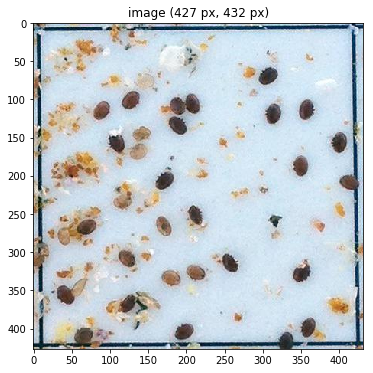

138


In [67]:

import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.filters
import skimage.color
import skimage.measure
import numpy as np
from skimage import exposure
%matplotlib inline
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)
img= skimage.io.imread(os.path.join(data_path, 'varroa-02.jpg'))
im_h, im_w, nb_color = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')
ax.set_title('image ({} px, {} px)'.format(im_h, im_w))
ax.axis('on')
plt.show()

#img = img < 0.2

#plt.figure(figsize=(12, 7))
#plt.imshow(img, cmap='gray')
#plt.show()

r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

#img = skimage.color.rgb2gray(img)
img_hist, bins = exposure.histogram(img)
#plt.plot(bins, img_hist)

#completeRegionGrowing parameters - varroa-01
#thresh_black = 40
#tolerance = 60
#rayon = 4
#nb_of_sigma = 2

#completeRegionGrowing parameters - varroa-02
thresh_black = 125
tolerance = 60
rayon = 5
nb_of_sigma = 2

#completeRegionGrowing parameters - varroa-03
#thresh_black = 40
#tolerance = 60
#rayon = 4
#nb_of_sigma = 2

#completeRegionGrowing parameters - varroa-04
#thresh_black = 100
#tolerance = 100
#rayon = 4
#nb_of_sigma = 2

#masks for opening
mask1 = np.ones((2*rayon,2*rayon))
mask2 = maskCircle(rayon)

#tolerance = 0.2
#img_hist, bins = exposure.histogram(r)
#plt.plot(bins, img_hist)
img_out = completeRegionGrowing(r, thresh_black, tolerance)

#print(np.max(img_out)) 
#plt.figure(figsize=(12, 7))
#plt.imshow(img_out, cmap='gray')
#plt.show()

img_out = remove_noise(img_out,nb_of_sigma)
skimage.morphology.binary_opening(img_out, mask2, out = img_out)

varroa = skimage.measure.label(img_out)
#plt.figure(figsize=(12, 7))
#plt.imshow(img_out, cmap='gray')
#plt.show()




Si l'image a été changée au dessus, il faut également changer le nom de l'image dans la première ligne du code qui suit.

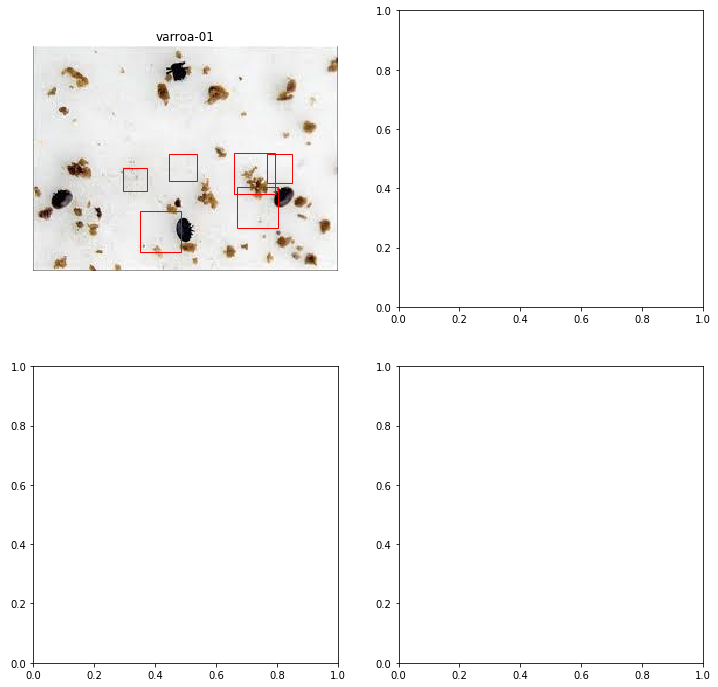

In [68]:
annotations_xmls = [parse_file(os.path.join(data_path, 'varroa-02') + '.xml')]
%matplotlib inline
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

Pour cette partie, il nous faut connaitre les coordonnées des rectangles représentant chaque mite. Comme il nous manque un critère suffisant pour calculer les dimensions et coordonnées de ces rectangles, nous avons opté pour une autre méthode. Nous utilisons uniquement le point central de chaque mite, et par rapport à celui-ci, nous estimons l'intersection over union. La méthode est simple. Nous imaginons que notre mite est représentée par un rectangle contenant les même dimensions que celui du ground truth, et part rapport à ça, nous pouvons appliquer un calcul de l'intersection et de l'union basé uniquement sur le désaxage du centre de notre mite, et du centre de la mite du ground truth. Ce calcul nous donne : Ainter = (width - deltaX)(height - deltaY), Aunion = 2*width*height - Ainter, où deltaX et deltaY représente le désaxage en x et y du centre de la mite avec le ground truth, et height et width représente les dimensions du rectangle représentant la mite du ground truth.

In [69]:
def computeTP(centers, xmin, ymin, xmax, ymax, threshold):
    # true positive
    nombre = 0
    xmin = list(xmin)
    ymin = list(ymin)
    xmax = list(xmax)
    ymax = list(ymax)
    for i in range(len(centers)):
         for j in range(len(xmin)):
                if(centers[i,1] < xmax[j]) and (centers[i,1] > xmin[j]) and (centers[i,0] < ymax[j]) and (centers[i,0] > ymin[j]):
                    #computation of intersection over union
                    width = xmax[j] - xmin[j]
                    height = ymax[j] - ymin[j]
                    meanX = (xmax[j] + xmin[j])/2
                    meanY = (ymax[j] + ymin[j])/2
                    deltaX = abs(centers[i,1] - meanX)
                    deltaY = abs(centers[i,0] - meanY)
                    Ainter = (width - deltaX)*(height - deltaY)
                    Aunion = 2*width*height - Ainter
                    interOverUnion = Ainter/Aunion
                    if(interOverUnion > threshold):
                        nombre = nombre + 1
                        del xmin[j]
                        del ymin[j]
                        del xmax[j]
                        del ymax[j]
                        break     
    return nombre

In [70]:
def computeFP(centers, xmin, ymin, xmax, ymax, threshold):
    # false positive
    nombre = 0
    xmin = list(xmin)
    ymin = list(ymin)
    xmax = list(xmax)
    ymax = list(ymax)
    for i in range(len(centers)):
        if(len(xmin) == 0):
            nombre = nombre + 1
        else:
            for j in range(len(xmin)):
                if(centers[i,1] < xmax[j]) and (centers[i,1] > xmin[j]) and (centers[i,0] < ymax[j]) and (centers[i,0] > ymin[j]):
                     #computation of intersection over union
                    width = xmax[j] - xmin[j]
                    height = ymax[j] - ymin[j]
                    meanX = (xmax[j] + xmin[j])/2
                    meanY = (ymax[j] + ymin[j])/2
                    deltaX = abs(centers[i,1] - meanX)
                    deltaY = abs(centers[i,0] - meanY)
                    Ainter = (width - deltaX)*(height - deltaY)
                    Aunion = 2*width*height - Ainter
                    interOverUnion = Ainter/Aunion
                    if(interOverUnion > threshold):
                        del xmin[j]
                        del ymin[j]
                        del xmax[j]
                        del ymax[j]
                        break   
                if(j == (len(xmin) - 1)):
                    nombre = nombre + 1
            
    return nombre

In [71]:
def computeFN(centers, xmin, ymin, xmax, ymax, threshold):
    #false negative
    nombre = 0
    xmin = list(xmin)
    ymin = list(ymin)
    xmax = list(xmax)
    ymax = list(ymax)
    centers_y = list(centers[:,0])
    centers_x = list(centers[:,1])
    for j in range(len(xmin)):
        if(len(centers_x) == 0):
            nombre = nombre + 1
        else :
            for i in range(len(centers_x)):
                if(centers_x[i] < xmax[j]) and (centers_x[i] > xmin[j]) and (centers_y[i] < ymax[j]) and (centers_y[i] > ymin[j]):
                     #computation of intersection over union
                    width = xmax[j] - xmin[j]
                    height = ymax[j] - ymin[j]
                    meanX = (xmax[j] + xmin[j])/2
                    meanY = (ymax[j] + ymin[j])/2
                    deltaX = abs(centers_x[i] - meanX)
                    deltaY = abs(centers_y[i] - meanY)
                    Ainter = (width - deltaX)*(height - deltaY)
                    Aunion = 2*width*height - Ainter
                    interOverUnion = Ainter/Aunion
                    if(interOverUnion > threshold):
                        del centers_x[i]
                        del centers_y[i]
                        break    
                if(i == len(centers_x) - 1):
                    nombre = nombre + 1
    return nombre

In [72]:
ground_truth_xmin = []
ground_truth_ymin = []
ground_truth_xmax = []
ground_truth_ymax = []

#threshold for intersection over union
threshold = 0.2

for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        ground_truth_xmin.append(anno['bbox'][0])
        ground_truth_ymin.append(anno['bbox'][1])
        ground_truth_xmax.append(anno['bbox'][2] + anno['bbox'][0])
        ground_truth_ymax.append(anno['bbox'][3] + anno['bbox'][1])

center = computeCenterPoints(varroa)
    
tp = computeTP(center, ground_truth_xmin, ground_truth_ymin, ground_truth_xmax, ground_truth_ymax, threshold)
print('true positive = {}'.format(tp))
fp = computeFP(center, ground_truth_xmin, ground_truth_ymin, ground_truth_xmax, ground_truth_ymax, threshold)
print('false positive = {}'.format(fp))
fn = computeFN(center, ground_truth_xmin, ground_truth_ymin, ground_truth_xmax, ground_truth_ymax, threshold)
print('false negative = {}'.format(fn))

true positive = 25
false positive = 6
false negative = 2


### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

Comme nous venons de calculer tp, fp, et fn juste avant, cette étape est triviale. Concernant les résultats, nous sommes plutôt satisfait car dans la plupart des cas, nous estimons bien le nombre de mites. Néanmoins, nous modifions des paramètre entre chaque image. Il serait bien de pouvoir automatiser cette tâche. Pour ce faire, il aurait été intéressant de disposer de détails supplémentaires concernant les images, comme l'agrandissement de l'image, et la taille et forme réelle d'une mite. Ainsi nous aurions pu tester d'autres techniques, comme le "matching" de l'image avec un masque qui contient une mite idéale. L'agrandissement de la photo nous permettrait là d'adapter la taille du masque selon la photo. 

In [73]:
if(tp + fp) == 0:
    precision = 0
else:
    precision = tp/(tp+fp)

if(tp + fn) == 0:
    recall = 0
else:
    recall = tp/(tp+fn)

if(precision + recall) == 0:
    F1_score = 0
else:
    F1_score = (2*precision*recall/(precision+recall))
print(F1_score)


0.8620689655172414
